# Exploratory analysis of corpus metadata

The corpus for our experiment has been selected to achieve several different goals. 

We need a substantial subset of books where we are confident both about a) the book's first publication date and b) the author's date of birth. An author's date of birth is pretty commonly recorded in library metadata, but it is hard to be confident that the publication date of any particular copy is also the *first* publication date for the title.

To get more confidence about publication date, we aligned HathiTrust metadata to metadata drawn from three sources: manual (title-by-title) [research at the University of Illinois,](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/B4D4H3) metadata manually recorded for the Chicago Novel Corpus, and [the NYPL digitized copy of the US copyright registry.](https://github.com/NYPL/catalog_of_copyright_entries_project) The copyright registry covers more volumes, but is restricted to the period 1923-1969.

This evidence is still not infallible.

E.g., although we took a book's first appearance in the copyright registry--if earlier than recorded publication date of our library copy--it is still possible that some books we have as post-1923 were first registered before 1923. The copyright registry won't give us the true earliest date for those. However, it did correct library metadata by 6 years or more in about 4% of cases.

Another source of error: we've used metadata where only a single author is recorded--but some books are coauthored, or were strongly influenced by an editor, whose identity may or may not be known. We've removed coauthored books that we can identify, but the role of editors will remain murkier. 

We plan to run two different experiments: 1) a regression experiment that asks whether publication date or DoB is more predictive for particular textual variables, and 2) structural equation modeling on sequences of books written by the same author. For the first (regression) experiment we want to hold nationality constant across time, to avoid creating confounds. For the second experiment, comparisons will take place only within an author's oeuvre, so authors of different nationalities can be used.

This means our corpus will contain two overlapping subsets:

1. Books by authors of known US nationality.
2. Books by authors who have more than three volumes in our corpus, of any nationality.

In order to create a corpus evenly distributed across time for topic modeling, we also added

3. Books to balance out the timeline, and extend it 20 years in both directions beyond the century (1890-1989) we plan to analyze. (There can otherwise be edge effects near the end of a timeline.)

Right now "balance" means "the same number of volumes in each year." But we might reconsider that to mean "the same number of words in each year," and remove some volumes from category (3) to even things out. (And also shrink the corpus to speed modeling a little.)

The cells below explore all three sets, visualizing the distribution of publication date and DoB.


In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter

In [61]:
corpus = pd.read_csv('metadata/modelcorpus.tsv', sep = '\t', low_memory = False, 
                     dtype = {'docid': object, 'hathi_author': object, 'hathi_title': object,
                            'authordate': object, 'birthyear': float, 'deathyear': float,
                            'chi_date': float, 'ukw_date': float, 'copyright_date': float,
                             'firstpub': int, 'datewrong': float, 'nationality': object,
                             'nonficprob': float, 'distance': float, 'copyright_corpus': bool,
                             'us_national': bool, 'pubdate_known': bool, 'authof3ormore': bool})               

In [54]:
corpus.head()

,docid,hathi_author,hathi_title,authordate,birthyear,deathyear,chi_date,ukw_date,copyright_date,est_comp_date,datewrong,nationality,nonficprob,distances,copyright_corpus,manual_corpus,us_national,pubdate_known,authof3ormore
0,nyp.33433082289871,A. L. O. E,"The giant killer, or, The battle which all mus...",1821-1893.,1821.0,1893.0,NaN,1861.0,NaN,1861,2.7,uk,0.000000,63.450466,False,True,False,True,True
1,nyp.33433075765176,A. L. O. E,"Christian love and loyalty; or, The rebel recl...",1821-1893.,1821.0,1893.0,NaN,1864.0,NaN,1864,1.7,uk,0.000000,60.814243,False,True,False,True,True
2,inu.39000000258256,A. L. O. E,Claudia : a tale,1821-1893.,1821.0,1893.0,NaN,1870.0,NaN,1870,-8.5,uk,0.000000,55.637050,False,True,False,True,True
3,uc1.b4975632,"Aakhus, Patricia",The voyage of Mael Duin's curragh,NaN,NaN,NaN,NaN,1989.0,NaN,1989,-14.1,us,0.000000,46.813640,False,True,True,True,False
4,inu.30000112046630,"Abbe, George",The winter house,1911-1989.,1911.0,1989.0,NaN,NaN,1957.0,1957,-13.0,NaN,0.243848,40.499164,True,False,False,True,True


## 1. Meaning of columns:

Not all of these columns are likely to be used in our analysis. Some are left over from the process of data cleaning, where we used various kinds of modeling to discover outliers in need of a manual check.

|field | meaning|
|------|---------|
| **docid**  | HathiTrust volume ID |
| **hathi_author** | Author name from HathiTrust, trailing punct trimmed|
|**hathi_title** | Short title from HathiTrust |
| **authordate** | string with bio dates, variety of nonstandard formats|
| **birthyear**   | year of author's birth, or NaN |
| **deathyear**  | year of author's death, or NaN |
| **chi_date**   | if present, we matched vol to Chicago Novel Corpus |
| **ukw_date**   | if present, we matched vol to Underwood, Kimutis, Witte 2020 |
| **copyright_date** | if present, we matched vol to US copyright registry |
| **firstpub** | best estimate for date of first publication |
| **datewrong** | not error in firstpub, but error in a predictive model used in cleaning |
| **nationality** | author's, if known |
| **nonficprob**  | used in cleaning |
| **distances** | from corpus centroid, used in cleaning |
| **copyright_corpus** | Boolean, whether firstpub confirmed against registry |
| **manual_corpus** | Boolean, whether firstpub confirmed by Chicago or UKW |
| **us_national** | Boolean, whether nationality == 'us' or 'US' |
| **pubdate_known** | Boolean, whether firstpub has been checked against any source but Hathi |
| **authof3ormore** | Boolean, whether hathi_author has 3 or more vols in this corpus |

## 2. Distribution of corpora across time

First, the whole corpus.

In [67]:
plt.figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

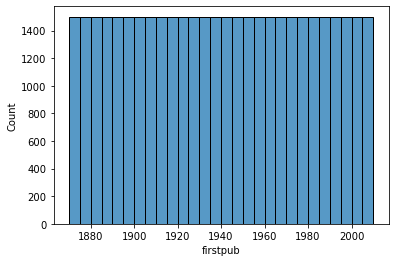

In [75]:
sns.histplot(corpus.firstpub, binwidth = 5)
plt.show()

This is unexciting. We have 42,000 volumes distributed evenly between 1870 and 2009, or 300 vols/year for 140 years.

### US national corpus

In [76]:
usnational = corpus.loc[corpus.us_national, ['firstpub', 'birthyear']]

In [77]:
usnational.shape

(6642, 2)

We have 6,642 volumes where US nationality is confirmed. But note, a smaller number of those have confirmed DoB.

In [84]:
usnational = usnational.loc[(~pd.isnull(usnational.birthyear)) &
                            (usnational.firstpub >= 1890) &
                            (usnational.firstpub <= 1989), : ]
usnational.shape

(4923, 2)

<AxesSubplot:xlabel='firstpub', ylabel='Count'>

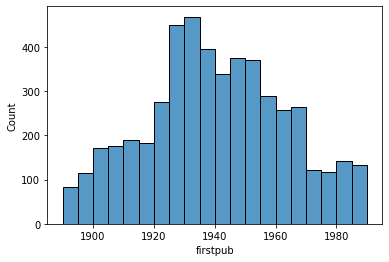

In [85]:
sns.histplot(usnational.firstpub, binwidth = 5)

The curve is a bit bell-shaped, because it was easier to confirm publication dates in the middle period covered by the copyright registry.

Date of birth is even more bell-shaped, because of the above distribution and the Central Limit Theorem.

<AxesSubplot:xlabel='birthyear', ylabel='Count'>

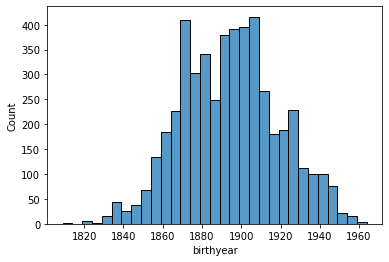

In [96]:
sns.histplot(usnational.birthyear, binwidth = 5)

### The sequence corpus

This is the subset of books where we have a sequence 3 or more by the same author.

In [103]:
sequencecorpus = corpus.loc[corpus.authof3ormore, :]
sequencecorpus.shape

(22812, 19)

<AxesSubplot:xlabel='firstpub', ylabel='Count'>

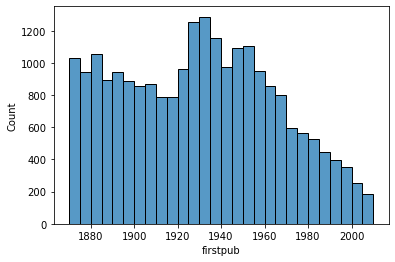

In [104]:
sns.histplot(sequencecorpus.firstpub, binwidth = 5)

We see there that the author-diversity of the corpus tends to increase after 1970. There are fewer books by multiple authors.

But don't get too excited about that mass of 22,812 books. The subset where we feel confident about publication year is smaller, and getting the *sequence* of books right is pretty important for this analysis. Also, we would ideally like to have author's DoB for this analysis too.

In [107]:
sum((sequencecorpus.pubdate_known) &  (~pd.isnull(sequencecorpus.birthyear)))

9910

How is that subset distributed?

<AxesSubplot:xlabel='firstpub', ylabel='Count'>

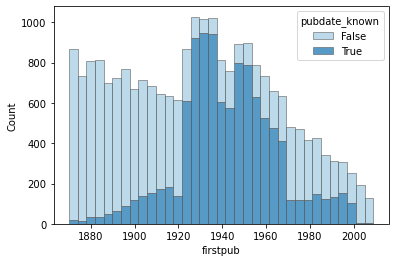

In [110]:
sns.histplot(sequencecorpus,
    x = "firstpub", hue="pubdate_known",
    multiple="stack",
    palette="Paired",
    edgecolor=".3",
    linewidth=.5)

As you can see, the corpus with known publication dates is concentrated in the mid-20c. This could be remediated a little by manual confirmation of pubdates on the "shoulders" of that curve. We do have books by multiple authors where DoB is known, or can be known. We just haven't confirmed pub dates.

What about DoB distribution?

In [111]:
knownsubset = sequencecorpus.loc[(sequencecorpus.pubdate_known == True) &
                                (~pd.isnull(sequencecorpus.birthyear)), : ]

<AxesSubplot:xlabel='birthyear', ylabel='Count'>

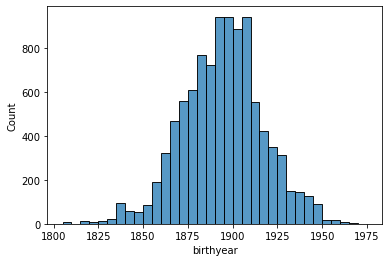

In [112]:
sns.histplot(knownsubset.birthyear, binwidth = 5)

<AxesSubplot:xlabel='age', ylabel='Count'>

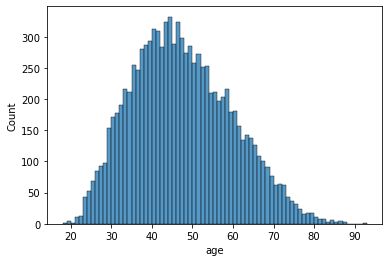

In [113]:
age = knownsubset.firstpub - knownsubset.birthyear
knownsubset = knownsubset.assign(age = age)
sns.histplot(knownsubset.age, binwidth = 1)

In [114]:
sum(age <= 30)

795

We only have 795 books published in a year when the author was 30 or younger. This will limit our ability to check for a "plasticity period."

## What about the distribution of words?

I selected an even number of volumes across time. But how even is the distribution of words?

In [118]:
wordspervol = Counter()

with open('/Users/tunder/work/tomallet/cohort1.txt', encoding = 'utf-8') as f:
    for line in f:
        words = line.split()
        docid = words[0].split('_')[0]
        numwords = len(words) - 2
        wordspervol[docid] += numwords

In [148]:
wordsdf = pd.DataFrame.from_dict(wordspervol, orient = 'index', columns = ['wordcount'])
wordsdf.reset_index(inplace = True)
wordsdf.rename(columns = {'index': 'docid'}, inplace = True)
wordsdf.sample(10)

,docid,wordcount
26105,wu.89015458334,46473
6269,pst.000005418633,81502
20599,njp.32101063691347,71807
27765,uc1.$b56691,89897
36092,mdp.39015053525005,106860
6915,mdp.39015008963723,40088
11025,mdp.39015050329450,111995
13085,uiuo.ark+=13960=t0zp4k66h,36162
3262,mdp.39015031233615,53230
9659,osu.32435069549608,86430


In [135]:
sum(wordspervol.values())

2041639107

We've got a total of two billion words in this corpus.

In [137]:
wordsdf = wordsdf.merge(corpus.loc[ : , ['docid', 'firstpub']], on = 'docid')

In [145]:
yearsum = wordsdf.groupby('firstpub').sum()
yearsum = yearsum.reset_index()
yearsum

,firstpub,wordcount
0,1870,24263955
1,1871,12640925
2,1872,17847241
3,1873,19925610
4,1874,12865874
...,...,...
135,2005,14911068
136,2006,13624208
137,2007,14765014
138,2008,15565189


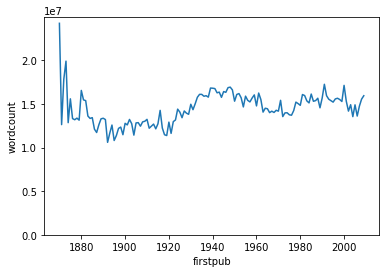

In [147]:
sns.lineplot(data = yearsum, x = 'firstpub', y = 'wordcount')
plt.ylim(0, None)
plt.show()

That's probably flat enough, but if we wanted to trim the size of the corpus we could do it by removing selected books to flatten the curve a bit.

### Preparing texts for LIWC

In [153]:
textstouse = set(corpus.loc[corpus.pubdate_known, 'docid'].tolist())

In [155]:
thisdoc = []
lastdocid = 'null'

with open('/Users/tunder/work/tomallet/cohort1.txt', encoding = 'utf-8') as f:
    for line in f:
        words = line.split()
        docid = words[0].split('_')[0]
        
        if docid != lastdocid and lastdocid != 'null':
            if lastdocid in textstouse:
                with open('/Users/tunder/work/tomallet/corpustexts/' + lastdocid + '.txt', mode = 'w', encoding = 'utf-8') as f1:
                    f1.write(' '.join(thisdoc))
            thisdoc = []
            
        thisdoc.extend(words[2: ])
        lastdocid = docid
        